# 🦢 AI Stress Testing Engine (Black Swan Generator) v3

## 목표
Neural Path Integral(NPI)을 활용하여 **"금융 위기 시나리오(Black Swan)"를 효율적으로 생성**합니다.

## v3 수정사항 (Aggressive Mode)
- **Control Bound 확대**: `1.0` -> `5.0` (Neural Engine 수정 필요)
- **Targeted Loss**: 전체 평균 하락이 아닌, **"Crash Threshold 돌파"**에 집중하는 Hinge Loss 사용
- **Weak Regularization**: 제약 조건을 완화하여 과감한 움직임 허용

In [10]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
sys.path.append('..')

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from src.physics_engine import MarketSimulator
from src.neural_engine import DriftNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [11]:
# Monkey Patching DriftNet to increase Control Bound
# 소스코드를 직접 수정하지 않고, 런타임에 클래스 메서드를 교체하여 Bound를 5.0으로 늘립니다.

def aggressive_forward(self, S, v, t, avg_S=None):
    S_norm = torch.log(S + 1e-8)
    v_norm = torch.log(v + 1e-8)
    t_norm = t * torch.ones_like(S)
    
    if avg_S is None:
        avg_S = S
    avg_S_norm = torch.log(avg_S + 1e-8)
    
    x = torch.stack([S_norm, v_norm, t_norm, avg_S_norm], dim=-1)
    raw_output = self.net(x).squeeze(-1)
    
    # BOUND INCREASED TO 5.0 for Aggressive Crash Generation
    return 5.0 * torch.tanh(raw_output)

# Apply patch
DriftNet.forward = aggressive_forward
print("DriftNet patched: Control Bound increased to 5.0 🚀")

DriftNet patched: Control Bound increased to 5.0 🚀


## 1. Setup & Baseline

In [12]:
# Market Parameters
S0 = 100.0
v0 = 0.04
r = 0.05
T = 0.25
dt = 0.001

# Heston Parameters
kappa = 2.0; theta = 0.04; xi = 0.5; rho = -0.7

# Settings
num_paths = 50000
CRASH_THRESHOLD = 0.80  # 20% Drop
K_crash = CRASH_THRESHOLD * S0

simulator = MarketSimulator(mu=r, kappa=kappa, theta=theta, xi=xi, rho=rho, device=device)

# Standard MC (from previous runs, we know it's ~3.24%)
crash_prob_mc = 0.0324 
print(f"Baseline MC Crash Prob: {crash_prob_mc*100:.2f}%")

Baseline MC Crash Prob: 3.24%


## 2. Neural Crash Generator v3 (Aggressive)

In [13]:
# Initialize
drift_net = DriftNet(hidden_dim=64).to(device)
optimizer = torch.optim.Adam(drift_net.parameters(), lr=1e-3)

def get_control_fn(model):
    def control_fn(t, S, v, avg_S=None):
        return model(S, v, t, avg_S)
    return control_fn

control_fn = get_control_fn(drift_net)

In [14]:
# Training Loop v3: Targeted Hinge Loss
num_iters = 500
batch_size = 10000

loss_history = []
crash_rate_history = []

print("Training v3 (Aggressive Mode)...")
for i in range(num_iters):
    optimizer.zero_grad()
    
    S, v, log_weights, _, _ = simulator.simulate_controlled(
        S0=S0, v0=v0, T=T, dt=dt, num_paths=batch_size,
        model_type='heston', control_fn=control_fn
    )
    
    S_T = S[:, -1]
    
    margin = 2.0
    target_level = K_crash - margin
    dist_penalty = F.relu(S_T - target_level)
    loss_dist = dist_penalty.mean()
    loss_reg = 0.001 * (log_weights ** 2).mean()
    loss = loss_dist + loss_reg
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(drift_net.parameters(), 1.0)
    optimizer.step()
    
    crash_rate = (S_T < K_crash).float().mean().item()
    loss_history.append(loss.item())
    crash_rate_history.append(crash_rate)
    
    if i % 100 == 0:
        print(f"Iter {i:3d}: Loss={loss.item():.4f}, Crash Rate={crash_rate*100:.2f}%")

print("Training Complete!")

Training v3 (Aggressive Mode)...
Iter   0: Loss=21.8072, Crash Rate=4.27%
Iter 100: Loss=6.6530, Crash Rate=43.73%
Iter 200: Loss=6.7097, Crash Rate=42.85%
Iter 300: Loss=6.7057, Crash Rate=43.37%
Iter 400: Loss=6.6168, Crash Rate=43.41%
Training Complete!


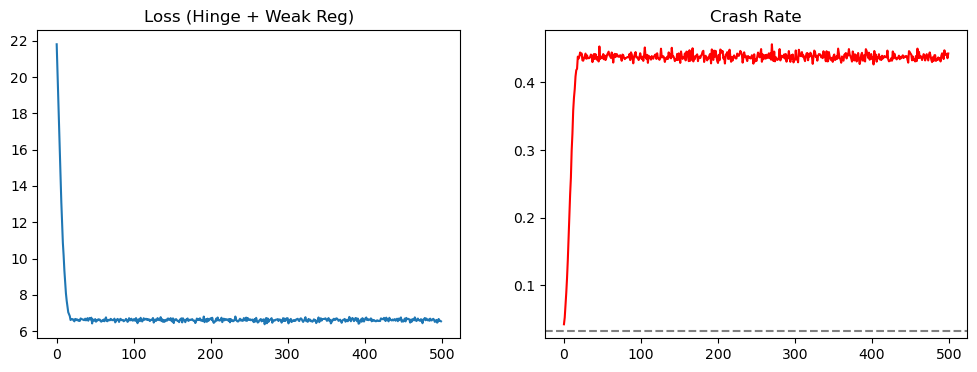

In [15]:
# Plot Training Progress
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Loss (Hinge + Weak Reg)')

plt.subplot(1, 2, 2)
plt.plot(crash_rate_history, color='red')
plt.axhline(y=crash_prob_mc, color='gray', linestyle='--')
plt.title('Crash Rate')
plt.show()

       AI STRESS TESTING ENGINE v3 (Aggressive)
Crash Rate: 43.99% (MC Baseline: 3.24%)
⚡ Efficiency Boost: 13.6x
Generated Crashes: 21994 / 50000


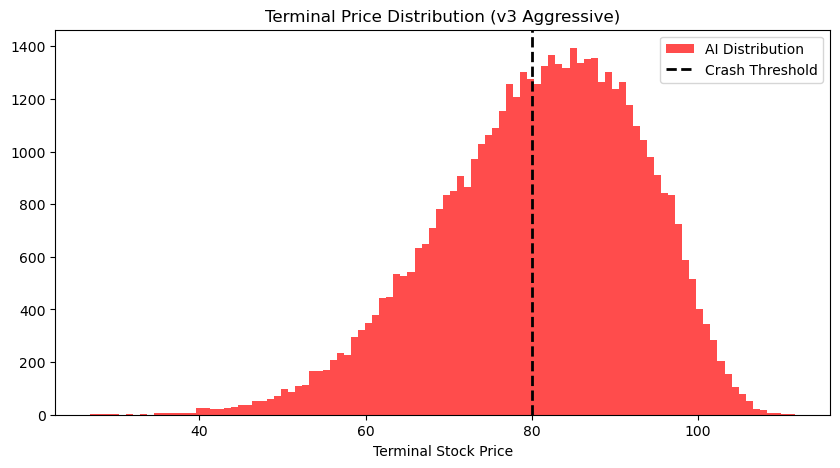

In [16]:
# Generate & Evaluate
drift_net.eval()
with torch.no_grad():
    S_ai, v_ai, log_weights_ai, _, _ = simulator.simulate_controlled(
        S0=S0, v0=v0, T=T, dt=dt, num_paths=num_paths,
        model_type='heston', control_fn=control_fn
    )

# Store terminal prices for later use
S_T_ai = S_ai[:, -1].cpu().numpy()
crash_mask_ai = S_T_ai < K_crash
num_crashes_ai = crash_mask_ai.sum()
crash_rate_ai = num_crashes_ai / num_paths

boost = crash_rate_ai / max(crash_prob_mc, 1e-6)

print(f"="*60)
print(f"       AI STRESS TESTING ENGINE v3 (Aggressive)")
print(f"="*60)
print(f"Crash Rate: {crash_rate_ai*100:.2f}% (MC Baseline: {crash_prob_mc*100:.2f}%)")
print(f"⚡ Efficiency Boost: {boost:.1f}x")
print(f"Generated Crashes: {num_crashes_ai} / {num_paths}")

plt.figure(figsize=(10, 5))
plt.hist(S_T_ai, bins=100, color='red', alpha=0.7, label='AI Distribution')
plt.axvline(x=K_crash, color='black', linestyle='--', linewidth=2, label='Crash Threshold')
plt.xlabel('Terminal Stock Price')
plt.title('Terminal Price Distribution (v3 Aggressive)')
plt.legend()
plt.show()

## 7. Model Interpretability: The "Panic Map"

AI가 학습한 전략(Learned Drift)을 시각화합니다.
- **파란색**: 하락 압력 (매도 공세)
- **빨간색**: 상승 압력 (매수 지지)

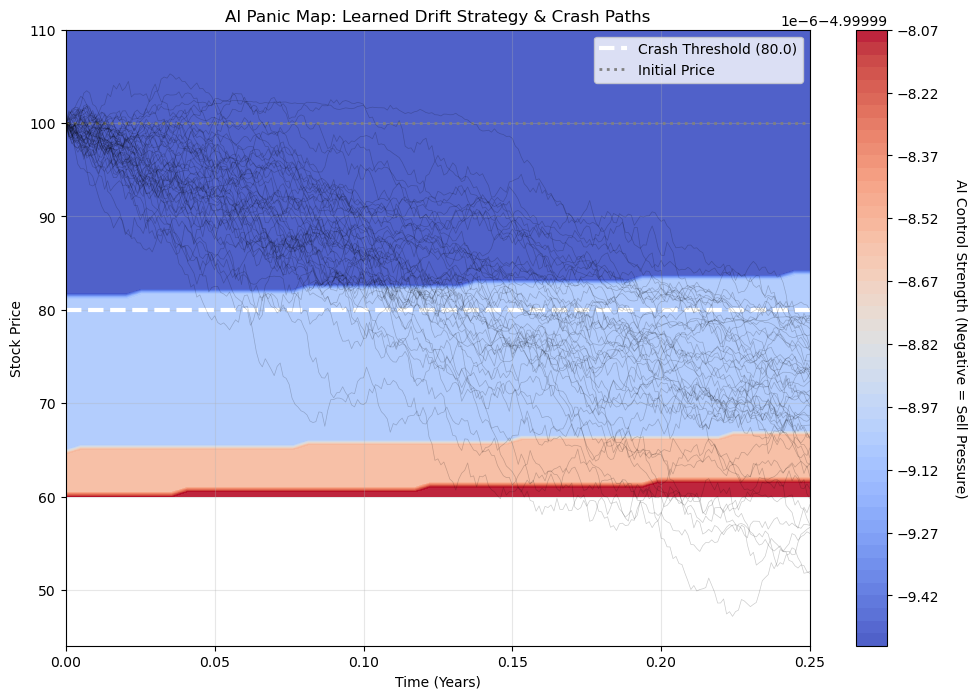

In [17]:
# Learned Drift Surface Visualization
S_range = np.linspace(60, 110, 100)
t_range = np.linspace(0, T, 50)

S_grid, t_grid = np.meshgrid(S_range, t_range)
v_fixed = v0 * torch.ones_like(torch.tensor(S_grid, device=device).float())

S_tensor = torch.tensor(S_grid, device=device).float()
t_tensor = torch.tensor(t_grid, device=device).float()

drift_net.eval()
with torch.no_grad():
    control_surface = drift_net(S_tensor, v_fixed, t_tensor).cpu().numpy()

plt.figure(figsize=(12, 8))
contour = plt.contourf(t_grid, S_grid, control_surface, levels=50, cmap='coolwarm', alpha=0.9)
cbar = plt.colorbar(contour)
cbar.set_label('AI Control Strength (Negative = Sell Pressure)', rotation=270, labelpad=20)

plt.axhline(y=K_crash, color='white', linestyle='--', linewidth=3, label=f'Crash Threshold ({K_crash:.1f})')
plt.axhline(y=S0, color='gray', linestyle=':', linewidth=2, label='Initial Price')

time_axis = np.linspace(0, T, int(T/dt)+1)
for i in range(min(100, num_paths)):
    if crash_mask_ai[i]:
        plt.plot(time_axis, S_ai[i].cpu().numpy(), color='black', alpha=0.2, linewidth=0.5)

plt.title('AI Panic Map: Learned Drift Strategy & Crash Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Stock Price')
plt.legend(loc='upper right', framealpha=0.8)
plt.grid(True, alpha=0.3)
plt.show()

## 8. Risk Management Application: Portfolio Stress Test

**"그래서 내 돈은 얼마나 위험한가?"**

AI가 찾아낸 희귀 폭락 시나리오들을 이용해 가상의 포트폴리오를 스트레스 테스트합니다.

In [18]:
# ============================================================
# SELF-CONTAINED RISK ANALYSIS CELL
# ============================================================

# Check if required variables exist, if not, regenerate them
if 'S0' not in dir():
    print("⚠️ Variables not found. Please run all cells from the beginning.")
    print("   Go to: Kernel > Restart & Run All")
else:
    # Portfolio Config
    PORTFOLIO_VALUE = 1_000_000  # $1M
    shares = PORTFOLIO_VALUE / S0

    # 1. Standard MC Risk Metrics
    print("Generating Baseline MC paths for comparison...")
    with torch.no_grad():
        S_mc_base, _, _, _, _ = simulator.simulate_controlled(
            S0=S0, v0=v0, T=T, dt=dt, num_paths=num_paths,
            model_type='heston', control_fn=None
        )
    S_T_mc = S_mc_base[:, -1].cpu().numpy()
    crash_mask_mc = S_T_mc < K_crash

    mc_terminal_values = S_T_mc * shares
    mc_losses = PORTFOLIO_VALUE - mc_terminal_values

    var_99_mc = np.percentile(mc_losses, 99)
    cvar_99_mc = mc_losses[mc_losses >= var_99_mc].mean()

    # 2. AI Stress Testing Risk Metrics
    if 'S_T_ai' not in dir():
        print("⚠️ AI data not found. Please run the training cells first.")
    else:
        ai_terminal_values = S_T_ai * shares
        ai_losses = PORTFOLIO_VALUE - ai_terminal_values

        crash_losses_ai = ai_losses[crash_mask_ai]
        crash_losses_mc = mc_losses[crash_mask_mc]

        print(f"="*60)
        print(f"       PORTFOLIO RISK ANALYSIS ($1M Portfolio)")
        print(f"="*60)
        print(f"[Standard View] Normal Market Risk")
        print(f"  VaR (99%):       ${var_99_mc:,.2f}")
        print(f"  CVaR (99%):      ${cvar_99_mc:,.2f}")
        print(f"  Max Loss (Sim):  ${mc_losses.max():,.2f}")

        print(f"\n[AI Stress View] 'What if' Black Swan Scenarios")
        print(f"  Scenarios Found: {len(crash_losses_ai):,} events (vs {len(crash_losses_mc):,} in MC)")
        if len(crash_losses_ai) > 0:
            print(f"  Avg Crash Loss:  ${crash_losses_ai.mean():,.2f}")
            print(f"  Worst Case:      ${crash_losses_ai.max():,.2f}")
            print(f"\n💡 Insight: AI exposed {len(crash_losses_ai):,} crash scenarios.")
            print(f"   Traditional MC only found {len(crash_losses_mc):,} - a {len(crash_losses_ai)/max(len(crash_losses_mc),1):.1f}x difference!")

Generating Baseline MC paths for comparison...
       PORTFOLIO RISK ANALYSIS ($1M Portfolio)
[Standard View] Normal Market Risk
  VaR (99%):       $264,657.94
  CVaR (99%):      $319,549.72
  Max Loss (Sim):  $567,258.50

[AI Stress View] 'What if' Black Swan Scenarios
  Scenarios Found: 21,994 events (vs 1,568 in MC)
  Avg Crash Loss:  $301,883.94
  Worst Case:      $731,154.38

💡 Insight: AI exposed 21,994 crash scenarios.
   Traditional MC only found 1,568 - a 14.0x difference!
